# OrganAIZ
## Agente de manejo de tiempo.

### Instalando las librerias necesarias

Para la correcta ejecucion del proyecto primero se deberan de instalar las librerias usadas para la implementacion del mismo.

In [90]:
!pip install anytree pandas
!pip install pytholog
!apt install swi-prolog
!pip install pykeen
!pip install -U scikit-fuzzy
!pip install sklearn
!pip install matplotlib


The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



Se importan las librerías relevantes.

In [91]:
import numpy as np
import pandas as pd
from anytree import NodeMixin, RenderTree
import pytholog as pl 
import math
import itertools
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse, silhouette_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score



Este metodo convierte cualquier lista de tareas sin orden en un arbol, para que el algoritmo de busqueda pueda luego seleccionar el mejor camino dentro del arbol.
Como entrada a modo de ejemplo pondremos un CSV de tareas sin orden, y a la salida el agente habrá ordenado las tareas en un arbol.

In [92]:
#Ordenar tareas en modo de arbol.

df = pd.read_csv("ordenar_tareas/tasksUnordered.csv") # leer el archivo csv original

df = df.sort_values(by=["TimeStart"]) # ordenar las tareas por su tiempo de inicio

parents = {} #diccionario para almacenar los padres de cada tarea

# recorrer cada tarea
for i, row in df.iterrows():
    # encontrar el tiempo de finalización de la tarea actual
    current_end_time = row["TimeStart"] + row["AvgTime"]
    # inicializar la distancia más cercana como infinito
    closest_distance = float("inf")
    # inicializar el padre más cercano como None
    closest_parent = None
    # buscar el padre más cercano en las tareas anteriores
    for j in range(i):
        # encontrar el tiempo de finalización de la tarea anterior
        previous_end_time = df.iloc[j]["TimeStart"] + df.iloc[j]["AvgTime"]
        # si la tarea anterior termina antes de que comience la tarea actual
        # y la distancia entre la tarea anterior y la actual es menor que la distancia más cercana actual
        # actualizar el padre más cercano y la distancia más cercana
        if previous_end_time <= row["TimeStart"] and (row["TimeStart"] - previous_end_time) < closest_distance:
            closest_distance = row["TimeStart"] - previous_end_time
            closest_parent = int(df.iloc[j]["TaskID"])
    # si se encontró un padre cercano, agregarlo al diccionario de padres
    if closest_parent is not None:
        parents[int(row["TaskID"])] = int(closest_parent)

# agregar la columna Parent al dataframe
df["Parent"] = df["TaskID"].map(parents)

# guardar el dataframe en un nuevo archivo csv
df.to_csv("ordenar_tareas/tasksOrdered.csv", index=False)


Este fragmento de código calcula la urgencia de cada tarea usando Redes de Creencias. anteriormente la urgencia se calculaba holisticamente, pero mediante este metodo logramos que tenga valores mas logicos y coherentes para ser usados como insumo luego.

In [93]:
"""
Código que calcula la urgencia de cada tarea usando Redes de Creencias.

Definir las funciones de creencia para cada factor:
"""

def creencia_avg_time(avg_time:int) -> float:
    """
    Creencia triangular para que las tareas con tiempo promedio de terminacion
    mas bajos sean prioriozadas. 
    
    Args:
        avg_time (int): Tiempo promedio que se demora en ejecutar y completar la tarea (minutos).
        
    Returns:
        float: Peso de la tarea de acuerdo con su tiempo promedio de terminacion, 
        entre mas se demore mas pequeño va a ser el peso que esta posea.  
    """
    if avg_time < 20:
        return 0.2
    elif avg_time < 40:
        return (avg_time - 10) / 10
    elif avg_time < 60:
        return 1 - (avg_time - 20) / 10
    else:
        return 0.2



def creencia_deadline(deadline:int) -> float:
    """
    Funcion de Creencia inversa para que las tareas que tengan una fecha limite
    mas pequeña (mas cerca del limite) sean priorizadas.
    Los valores más bajos tendran más prioridad y los valores más altos tendran menos prioridad.
    
    Args:
        deadline (int): Numero de dias que faltan para la fecha limite de la tarea. 
    
    Returns:
        float: Peso de la tarea de acuerdo con su fecha limite, 
        entre mas pequeña sea la fecha limite mas grande va a ser el peso de la tarea. 
    """
    if deadline < 1:
        return 1
    elif deadline < 5:
        return 1 - (deadline - 1) / 4
    elif deadline < 10:
        return 0.5 - (deadline - 5) / 10
    else:
        return 0



def creencia_is_hobby(is_hobby:bool) -> float:
    """
    Funcion de creencia que baja un poco la prioridad de una tarea si esta es un hobby.
    
    Args:
        is_hobby (bool): Si la tarea es o no un hobby.
        
    Returns:
        float: Peso de la tarea si la misma es o no un hobby.
    """
    if is_hobby:
        return 0.5
    else:
        return 1



def calcular_urgencia(avg_time:int, deadline:int, is_hobby:bool) -> float:
    """
    Construccion de una red de creencias que combine las funciones de creencia:
    creencia_avg_time, creencia_deadline y creencia_is_hobby usando una regla del producto.
    
    Args:
        avg_time (int): Tiempo promedio que se demora en ejecutar la tarea
        deadline (int): Numero de dias que faltan para la fecha limite de la tarea. 
        is_hobby (bool): Si la tarea es o no un hobby.
        
    Returns:
        float: Peso total asignado a la tarea, mediante el calculo de los diferentes
        pesos de sus artibutos avg_time, deadline e isHobby por medio de las funciones
        creencia_avg_time, creencia_deadline y creencia_is_hobby usando una regla del producto.
    """
    creencia_avg_time_res = creencia_avg_time(avg_time)
    creencia_deadline_res = creencia_deadline(deadline)
    creencia_is_hobby_res = creencia_is_hobby(is_hobby)
    urgencia_calc = creencia_avg_time_res * creencia_deadline_res * creencia_is_hobby_res
    return urgencia_calc



def escalar_urgencia(urgencia_calc:float) -> float:
    """
    Escalar la urgencia dentro de un intervalo de valores aceptados; [1,10].

    Args:
        urgencia_calc (float): Peso total asignado a la tarea, mediante el calculo de los diferentes
                               pesos de sus artibutos avg_time, deadline e isHobby por medio de las funciones
                               creencia_avg_time, creencia_deadline y creencia_is_hobby usando una regla del producto.

    Returns:
        float: Urgencia escalada al intervalo definido: maximo la urgencia puede tomar un valor de 10
        y minimo la urgencia puede tomar una valor de 1, [1,10].
    """
    urgencia_min = 1
    urgencia_max = 10
    urgencia = urgencia_min + ((urgencia_calc - 0) / (1 - 0)) * (urgencia_max - urgencia_min)
    return round(urgencia, 2)



df = pd.read_csv("urgencia/tareas.csv") # Leer el CSV

# Calcular la urgencia para cada tarea y escalar el valor entre 1 y 10 con máximo 2 espacios decimales
df["Urgency"] = df.apply(lambda row: escalar_urgencia(calcular_urgencia(row["AvgTime"], row["Deadline"], row["IsHobby"])), axis=1)

df.to_csv("urgencia/tareas_con_urgencia.csv", index=False) # Guardar el CSV con la nueva columna

Aquí vamos a crear la clase Task y TaskClass, que son los ladrillos constructores, las unidades mínimas con las que estaremos analizando cada tarea y armando nuestras soluciones.

In [94]:
class Task:
    def __init__(self, id:int, taskType:int, name:str, avgTime:int, 
                 timeStart:int, deadline:int, urgency:float, location:str, 
                 isHobby:bool, recurrency:int, bestOn:str, involves:str):
        """
        Constructor del objeto tarea.

        Args:
            id (int): Identificador unico de la tarea
            taskType (int): Categoria de la tarea a completar.
                1- Alimentación​,
                2- Aseo​,
                3- Actividad de Mascota​,
                4- Estudio​,
                5- Salud Física​,
                6- Plantas​,
                7- Gustos​,
                8- Actividad Social​,
                9- Actividad de Autocuidado y Orden.
            name (str): Nombre de la tarea
            avgTime (int): Tiempo promedio que se demora en ejecutar y completar la tarea (minutos).
            timeStart (int): _description_
            deadline (int): Numero de dias que faltan para la fecha limite de la tarea. 
            urgency (float): Nivel de prioridad
            location (str): Lugar fisico en el cual se realizara la tarea.
            isHobby (bool): Si la tarea es o no un hobby.
            recurrency (int): Cuantos dias en la semana suele repetirse la tarea.
            bestOn (str): Mejor en la mañana o en la tarde.
            involves (str): Sujetos terceros que involucra la tarea.
        """
        self.id=id
        self.taskType=taskType
        self.name=name
        self.avgTime=avgTime
        self.timeStart=timeStart
        self.deadline=deadline
        self.location=location
        self.urgency=urgency
        self.isHobby=isHobby
        self.recurrency=recurrency
        self.bestOn=bestOn
        self.involves=involves
        self.prioridad=""
        self.onPath=False
    
    
    
    def __str__(self) -> str:
        """
        To String del objeto Task. 
        Llevar los atributos del objeto a una forma legible a la
        hora de imprimir el objeto.

        Args:
            self (Task): Instancia de la clase Task.
        
        Returns:
            str: Representacion como texto del objeto Task.
        """
        return f"id: {self.id}, taskType: {self.taskType}, name: {self.name}, avgTime: {self.avgTime}, timeStart:{self.timeStart},deadline:{self.deadline},location:{self.location} urgency: {self.urgency}, isHobby: {self.isHobby}, recurrency:{self.recurrency}, bestOn:{self.bestOn} "



class TaskClass(Task, NodeMixin):  # Add Node feature
    def __init__(self,id:int, taskType:int, name:str, avgTime:int, 
                 timeStart:int, deadline:int, urgency:float, location:str, 
                 isHobby:bool, recurrency:int, bestOn:str, involves:str, 
                 parent:NodeMixin=None, children:NodeMixin=None):
        """
        Constructor del objeto Tarea como nodo de un arbol.

        Args:
            id (int): Identificador unico de la tarea
            taskType (int): Categoria de la tarea a completar.
                1- Alimentación​,
                2- Aseo​,
                3- Actividad de Mascota​,
                4- Estudio​,
                5- Salud Física​,
                6- Plantas​,
                7- Gustos​,
                8- Actividad Social​,
                9- Actividad de Autocuidado y Orden.
            name (str): Nombre de la tarea
            avgTime (int): Tiempo promedio que se demora en ejecutar y completar la tarea (minutos).
            timeStart (int): _description_
            deadline (int): Numero de dias que faltan para la fecha limite de la tarea. 
            urgency (float): Nivel de prioridad
            location (str): Lugar fisico en el cual se realizara la tarea.
            isHobby (bool):  Si la tarea es o no un hobby.
            recurrency (int): Cuantos dias en la semana suele repetirse la tarea.
            bestOn (str): Mejor en la mañana o en la tarde.
            involves (str): Sujetos terceros que involucra la tarea.
            parent (NodeMixin, optional): _description_. Defaults to None.
            children (NodeMixin, optional): _description_. Defaults to None.
        """
        super().__init__(id, taskType, name, avgTime, timeStart, deadline, urgency, location, isHobby, recurrency, bestOn, involves) #llamada al constructor padre
        self.parent = parent
        self.onPath=False
        if children:
            self.children = children

Esta es la clase auxiliar choice que nos sirve en el recorrido de la mejor solución.

In [95]:
class Choice():
    def __init__(self, move, urgency):
        self.move = move
        self.urgency = urgency



    def __str__(self):
        """
        To String del objeto Choice. 
        Llevar los atributos del objeto a una forma legible a la
        hora de imprimir el objeto.

        Args:
            self (Choice): Instancia de la clase Choice.
        
        Returns:
            str: Representacion como texto del objeto Choice.
        """
        return self.move + ": " + str(self.urgency)
    

Aquí tenemos el constructor de nuestro agente y clases relacionadas con su estructura básica.

In [96]:
#definamos la estructura más básica de nuestro agente
#la cual podrá ir creciendo según se definan nuevas características


class ScheduleAgent:
  def __init__(self, name:str, age:int, gender:str, taskList:pd.DataFrame, comments):
    """
    Constructor del objeto agente

    Args:
        name (str): Nombre del usuario
        age (int): Edad del usuario
        gender (str): Genero del usuario
        taskList (pd.DataFrame): Lista de tareas del usuario
        comments (_type_): _description_
    """
    self.name = name
    self.age = age
    self.gender = gender
    self.taskList = taskList
    self.notification = comments
    self.comments = comments
    self.rootNode = self.buildTree() #creo el arbol al inicializar el objeto
    
    
  
  def getNodesList(self) -> list:
    """
    Crear una lista de nodos del arbol de tareas de acuerdo a las
    tareas almacenadas en un archivo CSV.

    Args:
        self (ScheduleAgent): Instancia de la clase ScheduleAgent.

    Returns:
        list: Lista de nodos del arbol de tareas, cada nodo representa una tarea.
    """
    nodeList = []
    for i in range(0, len(self.taskList["Name"])):
        nodeList.append(TaskClass(
            id=self.taskList["TaskID"][i],
            taskType = self.taskList["TaskType"][i],
            name = self.taskList["Name"][i],
            avgTime = self.taskList["AvgTime"][i],
            timeStart = self.taskList["TimeStart"][i],
            deadline = self.taskList["Deadline"][i],
            urgency = self.taskList["Urgency"][i],
            location = self.taskList["Location"][i],
            isHobby = self.taskList["IsHobby"][i],
            recurrency = self.taskList["Recurrency"][i],
            bestOn = self.taskList["BestOn"][i],
            involves = self.taskList["Involves"][i],
        ))
    return nodeList
  
  
  
  def setParentNodes(self, nodeList:list) -> TaskClass:
    """
    Colocar a cada uno de los nodos del arbol de tareas su respectivo nodo padre.

    Args:
        self (ScheduleAgent): Instancia de la clase ScheduleAgent.
        nodeList (list): Lista de nodos del arbol de tareas, cada nodo representa una tarea.

    Returns:
        TaskClass: Nodo raiz del arbol de tareas, desde el nodo raiz se puede recorrer la totalidad del arbol.
    """
    for i in range(1, len(nodeList)):
        node = nodeList[i]
        node.parent = nodeList[(int(self.taskList["Parent"][i]))-1]
    return nodeList[0] #retorno root del arbol ya que desde root lo puedo recorrer todo

  
  
  def buildTree(self) -> TaskClass: 
    """
    Armar el arbol de tareas.
    En primera instancia crea una lista de nodos de tareas para 
    despues asignarles su respectivo nodo padre.

    Args:
        self (ScheduleAgent): Instancia de la clase ScheduleAgent.

    Returns:
        TaskClass: Nodo raiz del arbol de tareas, desde el nodo raiz se puede recorrer la totalidad del arbol.
    """
    nodeList = self.getNodesList()
    rootNode = self.setParentNodes(nodeList)
    return rootNode #retorno root del arbol ya que desde root lo puedo recorrer todo
    
    
    
  def printTaskTree(self) -> None:
    """
    Imprimir por completo el arbol de tareas. 
    
    Args:
        self (ScheduleAgent): Instancia de la clase ScheduleAgent.
    """
    for pre, fill, node in RenderTree(self.rootNode):
        print("%s%s" % (pre, node.name))   
  
  
  
  def miniMax(self, rootNode:Task, isMax:bool) -> Choice:
    """
    Algoritmo de busqueda miniMax para determinar la mayor cantidad de tareas de la mayor urgencia posible
    a completar en el minimo tiempo posible.

    Args:
        self (ScheduleAgent): Instancia de la clase ScheduleAgent.
        rootNode (Task): Nodo raiz del arbol de tareas, desde el nodo raiz se puede recorrer la totalidad del arbol.
        isMax (bool): ?

    Returns:
        Choice: Eleccion de rama y nodo del algortimo miniMax
    """
    children = rootNode.children
    try:
        l_choice = self.miniMax(children[0], not isMax)
        r_choice = self.miniMax(children[1], not isMax)

        if (isMax):
            if (l_choice.urgency > r_choice.urgency):
                return Choice("left", l_choice.urgency)
            else:
                return Choice("right", r_choice.urgency)
        else:
            if (l_choice.urgency < r_choice.urgency):
                return Choice("left", l_choice.urgency)
            else:
                return Choice("right", r_choice.urgency) 
    except IndexError:
        return Choice("end", self.rootNode.urgency)

Estructura para guardar el horario.

In [97]:
horario = {}

def agregar_tarea(node):
    horario[node.name] = node

# Mejor horario posible usando Minimax

Inicializamos el agente con un usuario ejemplo y calculamos la mejor solución para su horario.

In [98]:
#inicializando el agente para el usuario Ricardo
myAgent = ScheduleAgent(name="Ricardo",
                        age=36,
                        gender="Male",
                        taskList=pd.read_csv('agentTaskList.csv'),
                        comments = "")

isMax = True
currentNode = myAgent.rootNode
agregar_tarea(currentNode)

print("Comenzamos nuestro recorrido en el nodo: "+str(currentNode.name)+", con una urgencia de: "+str(currentNode.urgency))
currentNode.onPath=True

while (True):
    # run minimax on current node
    agentChoice = myAgent.miniMax(currentNode, isMax) 
    
    # make choice based on minimax search
    if (agentChoice.move == "left"):
        print ("Nos movemos a la izquierda con una urgencia de: " + str(currentNode.children[0].urgency)+ ", a la tarea: "+str(currentNode.children[0].name))
        currentNode.children[0].onPath=True
        currentNode = currentNode.children[0]
        agregar_tarea(currentNode)
    elif (agentChoice.move == "right"):
        print ("Nos movemos a la derecha con una urgencia de: " + str(currentNode.children[1].urgency)+ ", a la tarea: "+str(currentNode.children[1].name))
        currentNode.children[1].onPath=True
        currentNode = currentNode.children[1]
        agregar_tarea(currentNode)
    elif (agentChoice.move == "end"):
        print ("Hemos llegado al final del mejor recorrido")
        break

Comenzamos nuestro recorrido en el nodo: desayunar, con una urgencia de: 5
Nos movemos a la derecha con una urgencia de: 5, a la tarea: sacar al perro
Nos movemos a la derecha con una urgencia de: 7, a la tarea: regar plantas
Nos movemos a la derecha con una urgencia de: 6, a la tarea: jugar con el perro
Hemos llegado al final del mejor recorrido


Creamos estas estructuras de tipo diccionario para poder manejar las Tareas con mas facilidad.

In [99]:

# PARA ORGANIZAR LAS TAREAS SEGUN SUS ATRIBUTOS.

dictTasks = {}
dictHobbies = {}
dictHabits = {}


# METODO PARA AÑADIR LOS TASKS
def classifyTasks(node):
    dictTasks[node.name] = node
    if node.isHobby == True: 
        dictHobbies[node.name] = node
    if node.recurrency >= 5: 
        dictHabits[node.name] = node
    for node in node.descendants:
            if isinstance(node, Task):
                dictTasks[node.name] = node
                if node.isHobby == True: 
                    dictHobbies[node.name] = node
                if node.recurrency >= 5: 
                    dictHabits[node.name] = node

               
classifyTasks(myAgent.rootNode)

Código auxiliar para visualizar el horario de una mejor manera.

In [100]:
def pass_schedule_to_df(horario:dict):
    schedule_df = pd.DataFrame(columns = ["Avg Time to Complete",
                                          "Task Urgency",
                                          "Is it Hobby",
                                          "Task Location",
                                          "Task Recurrency"],
                               index = list(horario.keys()))
    for key in horario.keys():
        task_dict = horario[key].__dict__
        schedule_df.loc[key, 'Avg Time to Complete'] = task_dict['avgTime']
        schedule_df.loc[key,'Task Urgency'] = task_dict['urgency']
        schedule_df.loc[key,'Is it Hobby'] = key+' is a Hobby' if task_dict['isHobby'] else key+' is not a Hobby'
        schedule_df.loc[key,'Task Location'] = 'Uknown Location' if task_dict['location'] is None else task_dict['location']
        schedule_df.loc[key,'Task Recurrency'] = task_dict['recurrency']
    
    return schedule_df

In [101]:
pass_schedule_to_df(horario)

,Avg Time to Complete,Task Urgency,Is it Hobby,Task Location,Task Recurrency
desayunar,40,5,desayunar is not a Hobby,casa,7
sacar al perro,30,5,sacar al perro is not a Hobby,casa,7
regar plantas,15,7,regar plantas is not a Hobby,casa,2
jugar con el perro,30,6,jugar con el perro is not a Hobby,casa,6


Se añade la base de conocimiento al archivo, creada a partir del txt que se llena con la información de las tareas, y se llenan los diccionarios anteriores.

# Base de Conocimiento usando Lógica Proposicional

In [102]:
# AÑADIR LAS TAREAS DE LA ESTRUCTURA ANYTREE AL ARCHIVO DE LOGICA DE PROLOG

# reinicia entre corridas el txt, aqui se ponen la reglas basicas de la logica del agente
with open("./logica/logica_agente.txt", "w") as archivo:
    archivo.write("sameLocation(X,Y) :- inLocation(X,Z1), inLocation(Y,Z2), Z1 == Z2 -> sameLocation(X,Y)." + '\n')
    archivo.write("differentLocation(X,Y) :- inLocation(X,Z1), inLocation(Y,Z2), Z1 \= Z2 -> differentLocation(X,Y)." + '\n')
    archivo.write("differentDuration(X,Y) :- taskDuration(X,D1), taskDuration(Y,D2), D1 \= D2 -> differentDuration(X,Y)." + '\n')
    archivo.write("higherUrgency(X,Y) :- hasUrgency(X,U1), hasUrgency(Y,U2), U1 > U2 -> higherUrgency(X,Y)." + '\n')
    archivo.write("isDailyTask(X) :- taskRecurrency(X,R), R >= 7 -> isDailyTask(X)." + '\n')
    archivo.write("isWeeklyTask(X) :- taskRecurrency(X,R), R < 7, R > 1 -> isWeeklyTask(X)." + '\n')
    archivo.write("isMonthlyTask(X) :- taskRecurrency(X,R), R == 1 -> isMonthlyTask(X)." )
archivo.close()

with open('./logica/logica_agente.txt', mode='a') as archivo:
    archivo.write("\nisAgent("+myAgent.name+")" +'\n')
archivo.close()


# METODO PARA AÑADIR LOS TASKS
def addAllTasks(node):
    with open('./logica/logica_agente.txt', mode='a') as archivo:

        #dictTasks[node.name] = node
        archivo.write("isTask("+node.name + ",True)" + '\n')
        archivo.write("inLocation("+node.name + "," + node.location +")" + '\n')
        archivo.write("hasDeadline("+node.name + "," + str(node.deadline) +")" + '\n')
        archivo.write("hasUrgency("+node.name + "," + str(node.urgency) +")" + '\n')
        archivo.write("isBestOn("+node.name + "," + node.bestOn +")" + '\n')
        archivo.write("taskRecurrency("+node.name + "," + str(node.recurrency) +")" + '\n')
        archivo.write("inTodaysSchedule("+node.name + "," + "True" + ")" + '\n')


        if node.onPath == True:
            archivo.write("inTodaysSchedule("+node.name + ",True)" + '\n')
        elif node.onPath == False:
            archivo.write("inTodaysSchedule("+node.name + ",False)" + '\n')
        if node.involves != "" and node.involves != np.nan:
            archivo.write("involvesWho("+node.name + "," + str(node.involves) +")" + '\n')
        if node.isHobby == True: 
            # dictHobbies[node.name] = node
            archivo.write("isHobby("+node.name + ")" + '\n')
        if node.recurrency >= 5: 
            # dictHabits[node.name] = node
            archivo.write("isHabit("+node.name + ")" + '\n')
        
        for node in node.descendants:
            if isinstance(node, Task):
                    # dictTasks[node.name] = node
                    archivo.write("isTask("+node.name + ",True)" + '\n')
                    archivo.write("inLocation("+node.name + "," + node.location +")" + '\n')
                    archivo.write("hasDeadline("+node.name + "," + str(node.deadline) +")" + '\n')
                    archivo.write("hasUrgency("+node.name + "," + str(node.urgency) +")" + '\n')
                    archivo.write("isBestOn("+node.name + "," + node.bestOn +")" + '\n')
                    archivo.write("taskRecurrency("+node.name + "," + str(node.recurrency) +")" + '\n')
                    if node.onPath == True:
                        archivo.write("inTodaysSchedule("+node.name + ",True)" + '\n')
                    elif node.onPath == False:
                        archivo.write("inTodaysSchedule("+node.name + ",False)" + '\n')
                    if node.involves != "" and node.involves != np.nan:
                        archivo.write("involvesWho("+node.name + "," + str(node.involves) +")" + '\n')
                    if node.isHobby == True: 
                        # dictHobbies[node.name] = node
                        archivo.write("isHobby("+node.name + ",True)" + '\n')
                    if node.recurrency >= 5: 
                        # dictHabits[node.name] = node
                        archivo.write("isHabit("+node.name + ",True)" + '\n')
                             
    archivo.close()              
               
addAllTasks(myAgent.rootNode)

# Base de conocimiento
KB2 = pl.KnowledgeBase("KB2")
KB2.from_file("./logica/logica_agente.txt")

facts and rules have been added to KB2.db


Este es un ejemplo de como quedaron llenos los diccionarios anteriormente descritos.

In [103]:
print("Tasks: " + str(dictTasks))
print(str(len(dictTasks)))
print(dictTasks['bañarse'])
print(dictTasks['bañarse'].location)
print("")
print("Hobbies: " + str(dictHobbies))
print("")
print("Habits: " + str(dictHabits))

Tasks: {'desayunar': <__main__.TaskClass object at 0x1347b85b0>, 'bañarse': <__main__.TaskClass object at 0x1347b8130>, 'hacer la tarea': <__main__.TaskClass object at 0x1347b93c0>, 'almorzar': <__main__.TaskClass object at 0x1347b92d0>, 'hacer ejercicio': <__main__.TaskClass object at 0x1347b9390>, 'estudiar para el parcial': <__main__.TaskClass object at 0x1347b9330>, 'escuchar musica': <__main__.TaskClass object at 0x1347b92a0>, 'leer documentacion': <__main__.TaskClass object at 0x1347b9270>, 'sacar al perro': <__main__.TaskClass object at 0x1347b83d0>, 'hacer estiramientos': <__main__.TaskClass object at 0x1347b9300>, 'ver netflix': <__main__.TaskClass object at 0x1347b91e0>, 'reunirse con amigos': <__main__.TaskClass object at 0x1347b91b0>, 'regar plantas': <__main__.TaskClass object at 0x1347b9360>, 'ordenar el cuarto': <__main__.TaskClass object at 0x1347b9210>, 'jugar con el perro': <__main__.TaskClass object at 0x1347b9180>}
15
id: 2, taskType: 2, name: bañarse, avgTime: 45, 

Estos son ejemplos de queries con nuestra base de conocimiento recientemente creada.

In [104]:
# Ejemplos de Queries

# Queries sobre nuestros datos

print("Preguntamos sobre una tarea que no esta en el dataframe")
print(KB2.query(pl.Expr("isTask(morir)")))

print("Preguntamos datos sobre una tarea que sí esta en el dataframe")
print(KB2.query(pl.Expr("isTask(almorzar)")))

print("Preguntamos por clasificaciones")
print(KB2.query(pl.Expr("isHobby(almorzar)")))
print(KB2.query(pl.Expr("isHabit(almorzar)")))

print("Preguntamos datos sobre relaciones entre tareas")
print(KB2.query(pl.Expr("sameLocation(almorzar,regar plantas)")))
print(KB2.query(pl.Expr("sameLocation(desayunar,ordenar el cuarto)")))


print("Distinguimos que tareas son las que se agregaron al horario de hoy")
print(KB2.query(pl.Expr("inTodaysSchedule(almorzar,True)"))) 
print(KB2.query(pl.Expr("inTodaysSchedule(almorzar,False)"))) 
print(KB2.query(pl.Expr("inTodaysSchedule(regar plantas,True)")))
print(KB2.query(pl.Expr("inTodaysSchedule(regar plantas,False)")))


print("--- --- ---")

# Crear consulta en pytholog
# Ejecutar consulta sobre la base de conocimientos KB2

results = KB2.query(pl.Expr("isDailyTask(hacer la tarea)"))
print(results)
results = KB2.query(pl.Expr("isDailyTask(X)"))
print(results)



Preguntamos sobre una tarea que no esta en el dataframe
['No']
Preguntamos datos sobre una tarea que sí esta en el dataframe
['No']
Preguntamos por clasificaciones
['No']
['No']
Preguntamos datos sobre relaciones entre tareas
['No']
['No']
Distinguimos que tareas son las que se agregaron al horario de hoy
['Yes']
['Yes']
['Yes']
['Yes']
--- --- ---
['No']
['No']


# Cálculo de la prioridad de cada tarea usando Logica Difusa

Creamos un sistema de lógica difusa con la variable prioridad y se le asigna a cada una de las tareas.

In [105]:
# Definir variables de entrada y salida
urgencia = ctrl.Antecedent(np.arange(1, 11, 1), 'urgencia')
prioridad = ctrl.Consequent(np.arange(0, 11, 1), 'prioridad')

# Definir los conjuntos difusos y las funciones de pertenencia correspondientes
urgencia['muy_baja'] = fuzz.trimf(urgencia.universe, [1, 1, 3])
urgencia['baja'] = fuzz.trimf(urgencia.universe, [1, 3, 5])
urgencia['media'] = fuzz.trimf(urgencia.universe, [3, 5, 7])
urgencia['alta'] = fuzz.trimf(urgencia.universe, [5, 7, 9])
urgencia['muy_alta'] = fuzz.trimf(urgencia.universe, [7, 10, 10])

prioridad['baja'] = fuzz.trimf(prioridad.universe, [0, 0, 5])
prioridad['media'] = fuzz.trimf(prioridad.universe, [0, 5, 10])
prioridad['alta'] = fuzz.trimf(prioridad.universe, [5, 10, 10])

# Definir las reglas difusas
regla1 = ctrl.Rule(urgencia['muy_baja'], prioridad['baja'])
regla2 = ctrl.Rule(urgencia['baja'], prioridad['baja'])
regla3 = ctrl.Rule(urgencia['media'], prioridad['media'])
regla4 = ctrl.Rule(urgencia['alta'], prioridad['alta'])
regla5 = ctrl.Rule(urgencia['muy_alta'], prioridad['alta'])

# Definir el sistema de control difuso
sistema = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5])
asignar_prioridad = ctrl.ControlSystemSimulation(sistema)

def escribirPrioridad(prioridad):
    # Imprimir la prioridad asignada en forma de cadena de texto
    if prioridad_tarea <= 2.5:
        print("La prioridad de la tarea es baja")
    elif prioridad_tarea <= 7.5:
        print("La prioridad de la tarea es media")
    else:
        print("La prioridad de la tarea es alta")




for clave, valor in dictTasks.items():
    print("asigno Prioridad para: " +clave +", que tiene urgencia: "+ str(round(valor.urgency,2)))

    # Asignar un valor de urgencia para la tarea de desayunar
    asignar_prioridad.input['urgencia'] = valor.urgency

    # Calcular el resultado del sistema de control difuso
    asignar_prioridad.compute()

    # Obtener la salida (prioridad)
    prioridad_tarea = asignar_prioridad.output['prioridad']
    print('La prioridad de la tarea es:', round(prioridad_tarea,2))
    valor.prioridad= prioridad_tarea
    escribirPrioridad(valor.prioridad)

asigno Prioridad para: desayunar, que tiene urgencia: 5
La prioridad de la tarea es: 5.0
La prioridad de la tarea es media
asigno Prioridad para: bañarse, que tiene urgencia: 2
La prioridad de la tarea es: 1.94
La prioridad de la tarea es baja
asigno Prioridad para: hacer la tarea, que tiene urgencia: 7
La prioridad de la tarea es: 8.33
La prioridad de la tarea es alta
asigno Prioridad para: almorzar, que tiene urgencia: 4
La prioridad de la tarea es: 4.4
La prioridad de la tarea es media
asigno Prioridad para: hacer ejercicio, que tiene urgencia: 3
La prioridad de la tarea es: 1.67
La prioridad de la tarea es baja
asigno Prioridad para: estudiar para el parcial, que tiene urgencia: 9
La prioridad de la tarea es: 8.19
La prioridad de la tarea es alta
asigno Prioridad para: escuchar musica, que tiene urgencia: 1
La prioridad de la tarea es: 1.67
La prioridad de la tarea es baja
asigno Prioridad para: leer documentacion, que tiene urgencia: 5
La prioridad de la tarea es: 5.0
La prioridad

In [106]:
"""
# Definir variables de entrada y salida
urgencia = ctrl.Antecedent(np.arange(1, 11, 1), 'urgencia')
prioridad = ctrl.Consequent(np.arange(0, 11, 1), 'prioridad')
deadline = ctrl.Antecedent(np.arange(1, 11, 1), 'deadline')

# Definir los conjuntos difusos y las funciones de pertenencia correspondientes
urgencia['muy_baja'] = fuzz.trimf(urgencia.universe, [1, 1, 3])
urgencia['baja'] = fuzz.trimf(urgencia.universe, [1, 3, 5])
urgencia['media'] = fuzz.trimf(urgencia.universe, [3, 5, 7])
urgencia['alta'] = fuzz.trimf(urgencia.universe, [5, 7, 9])
urgencia['muy_alta'] = fuzz.trimf(urgencia.universe, [7, 10, 10])

prioridad['baja'] = fuzz.trimf(prioridad.universe, [0, 0, 5])
prioridad['media'] = fuzz.trimf(prioridad.universe, [0, 5, 10])
prioridad['alta'] = fuzz.trimf(prioridad.universe, [5, 10, 10])

deadline['muy_baja'] = fuzz.trimf(deadline.universe, [1, 1, 3])
deadline['baja'] = fuzz.trimf(deadline.universe, [1, 3, 5])
deadline['media'] = fuzz.trimf(deadline.universe, [3, 5, 7])
deadline['alta'] = fuzz.trimf(deadline.universe, [5, 7, 9])
deadline['muy_alta'] = fuzz.trimf(deadline.universe, [7, 10, 10])

# Definir las reglas difusas
regla1 = ctrl.Rule(urgencia['muy_baja'] & deadline['muy_alta'], prioridad['baja'])
regla2 = ctrl.Rule(urgencia['baja'] & deadline['alta'], prioridad['baja'])
regla3 = ctrl.Rule(urgencia['media'] & deadline['media'], prioridad['media'])
regla4 = ctrl.Rule(urgencia['alta'] & deadline['baja'], prioridad['alta'])
regla5 = ctrl.Rule(urgencia['muy_alta'] & deadline['muy_baja'], prioridad['alta'])

# Definir el sistema de control difuso
sistema = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5])
asignar_prioridad = ctrl.ControlSystemSimulation(sistema)

def escribirPrioridad(prioridad):
    # Imprimir la prioridad asignada en forma de cadena de texto
    if prioridad_tarea <= 2.5:
        print("La prioridad de la tarea es baja")
    elif prioridad_tarea <= 7.5:
        print("La prioridad de la tarea es media")
    else:
        print("La prioridad de la tarea es alta")




for clave, valor in dictTasks.items():
    print("asigno Prioridad para: " +clave +", que tiene urgencia: "+ str(round(valor.urgency,2)) +", y deadline: " + str(round(valor.deadline,2)))

    # Asignar un valor de urgencia para la tarea de desayunar
    asignar_prioridad.input['urgencia'] = valor.urgency
    asignar_prioridad.input['deadline'] = valor.deadline

    # Calcular el resultado del sistema de control difuso
    asignar_prioridad.compute()

    # Obtener la salida (prioridad)
    prioridad_tarea = asignar_prioridad.output['prioridad']
    valor.prioridad= prioridad_tarea
    print('La prioridad de la tarea es:', round(valor.prioridad,2))
    escribirPrioridad(valor.prioridad)


"""


'\n# Definir variables de entrada y salida\nurgencia = ctrl.Antecedent(np.arange(1, 11, 1), \'urgencia\')\nprioridad = ctrl.Consequent(np.arange(0, 11, 1), \'prioridad\')\ndeadline = ctrl.Antecedent(np.arange(1, 11, 1), \'deadline\')\n\n# Definir los conjuntos difusos y las funciones de pertenencia correspondientes\nurgencia[\'muy_baja\'] = fuzz.trimf(urgencia.universe, [1, 1, 3])\nurgencia[\'baja\'] = fuzz.trimf(urgencia.universe, [1, 3, 5])\nurgencia[\'media\'] = fuzz.trimf(urgencia.universe, [3, 5, 7])\nurgencia[\'alta\'] = fuzz.trimf(urgencia.universe, [5, 7, 9])\nurgencia[\'muy_alta\'] = fuzz.trimf(urgencia.universe, [7, 10, 10])\n\nprioridad[\'baja\'] = fuzz.trimf(prioridad.universe, [0, 0, 5])\nprioridad[\'media\'] = fuzz.trimf(prioridad.universe, [0, 5, 10])\nprioridad[\'alta\'] = fuzz.trimf(prioridad.universe, [5, 10, 10])\n\ndeadline[\'muy_baja\'] = fuzz.trimf(deadline.universe, [1, 1, 3])\ndeadline[\'baja\'] = fuzz.trimf(deadline.universe, [1, 3, 5])\ndeadline[\'media\'] = f

Se describe cuales de las tareas que no están en el horario actual tienen mayor prioridad para que el usuario pueda priorizarlas lo mas pronto posible en caso de que tenga tiempo extra o deba cancelar otra actividad pendiente.

In [107]:
# Crear un diccionario vacío para almacenar las tareas que no están en horario
nuevas_tareas = {}

# Iterar sobre las claves en dictTasks
for tarea in dictTasks.keys():
    
    # Comprobar si la tarea no está en horario
    if tarea not in horario:
        
        # Si no está en horario, agregarla al nuevo diccionario
        nuevas_tareas[tarea] = dictTasks[tarea]



print("En caso de no poder realizar alguna de las tareas en tu horario te recomendamos tomar alguna de alta prioridad,. \n a continuacion te las listamos en el orden recomendado: \n")

# Ordenar las tareas por prioridad (de mayor a menor)
tareas_ordenadas = sorted(nuevas_tareas.values(), key=lambda x: x.prioridad, reverse=True)

# Recorrer las tareas ordenadas e imprimir su prioridad
for tarea in tareas_ordenadas:
    print("- " +tarea.name + ", con una prioridad de: " + str(round(tarea.prioridad, 2) ))

En caso de no poder realizar alguna de las tareas en tu horario te recomendamos tomar alguna de alta prioridad,. 
 a continuacion te las listamos en el orden recomendado: 

- hacer la tarea, con una prioridad de: 8.33
- estudiar para el parcial, con una prioridad de: 8.19
- leer documentacion, con una prioridad de: 5.0
- almorzar, con una prioridad de: 4.4
- reunirse con amigos, con una prioridad de: 4.4
- ordenar el cuarto, con una prioridad de: 4.4
- bañarse, con una prioridad de: 1.94
- hacer estiramientos, con una prioridad de: 1.94
- hacer ejercicio, con una prioridad de: 1.67
- escuchar musica, con una prioridad de: 1.67
- ver netflix, con una prioridad de: 1.67


In [108]:
for Task in dictTasks.values():
    print(str(Task.prioridad))

print("hi")

5.000000000000001
1.9444444444444444
8.333333333333334
4.404761904761905
1.6666666666666665
8.194444444444445
1.6666666666666665
5.000000000000001
5.000000000000001
1.9444444444444444
1.6666666666666665
4.404761904761905
8.333333333333334
4.404761904761905
5.595238095238095
hi


# Aprendizaje con Clusters de clasificación

En este código, se utilizan cuatro características para cada tarea: la duración promedio, el tiempo de inicio, la fecha límite y la urgencia. Se crea una matriz de características con estas características para todas las tareas en dictTasks. Luego, se aplica K-means con 3 clusters y se asigna cada tarea a su respectivo cluster.

Vamos a usar cada cluster como tres grandes grupos: A, B y C donde se pueden clasificar tareas, los clusters actuaran como la forma en que el agente las pre-clasificará para facilidad del usuario, pero el objetivo es que este pueda moverlas a su conveniencia para visualizarlas y relacionarlas con mayor presición según sus necesidades.

In [109]:
# --- CREACION DE CLUSTERS DE TAREAS ---

#print(dictTasks)

# Crear la matriz de características para todas las tareas
features_matrix = []
for task_name, task in dictTasks.items():
    features = [task.avgTime, task.timeStart, task.urgency, task.deadline]
    features_matrix.append(features)
    
# Convertir la lista en una matriz NumPy
X = np.array(features_matrix)

print(X)

cluster_names = ["Tareas A", "Tareas B", "Tareas C"]

# Aplicar K-means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Asignar cada tarea a su respectivo cluster
for i, task_name in enumerate(dictTasks.keys()):
    dictTasks[task_name].cluster = kmeans.labels_[i]




[[ 40 480   5   1]
 [ 45 525   2   1]
 [ 60 590   7   5]
 [ 40 720   4   1]
 [ 50 630   3   4]
 [ 65 600   9   2]
 [ 20 660   1   7]
 [ 50 645   5   6]
 [ 30 530   5   2]
 [ 10 540   2   7]
 [ 60 655   3   8]
 [ 80 780   4   8]
 [ 15 605   7   5]
 [ 45 750   4   5]
 [ 30 790   6   7]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Los centroides son los puntos centrales de cada cluster y proporcionan información sobre las características promedio de los datos que pertenecen a ese cluster. Al conocer las coordenadas de los centroides, puede inferir qué características tienen más influencia en la formación de cada cluster.

Además, los centroides también se pueden utilizar para predecir a qué cluster pertenecerá una nueva tarea o dato que tenga características similares a las tareas ya agrupadas.



In [110]:
# Obtener los centroides de cada cluster
centroids = kmeans.cluster_centers_

# Imprimir los centroides
print("Coordenadas de los centroides de cada cluster:")
print(centroids)

Coordenadas de los centroides de cada cluster:
[[ 45.71428571 626.42857143   5.           5.28571429]
 [ 48.75       760.           4.5          5.25      ]
 [ 31.25       518.75         3.5          2.75      ]]


Observaremos que otra información relevante podemos imprimir:

In [117]:
# Obtener el número de tareas en cada grupo:
print("numero de tareas de cada grupo: ")
task_counts = pd.Series(kmeans.labels_).value_counts()
print(task_counts)

#Obtener las características promedio de cada grupo:
print("características promedio de cada grupo")
group_means = pd.DataFrame(X).groupby(kmeans.labels_).mean()
#print(group_means)
print(pd.DataFrame(X).groupby(kmeans.labels_).mean())

# Obtener las tareas pertenecientes a cada grupo:
print("Tareas en cada grupo:")
grouped_tasks = {}
for i, task_name in enumerate(dictTasks.keys()):
    group_id = kmeans.labels_[i]
    if group_id not in grouped_tasks:
        grouped_tasks[group_id] = []
    grouped_tasks[group_id].append(task_name)
    
for group_id, task_names in grouped_tasks.items():
    print(f"Tasks in group {group_id}:")
    print(task_names)


# Imprimir las tareas por su grupo cluster

for group_id, task_names in grouped_tasks.items():
    print(f"{cluster_names[group_id]}:")
    print(task_names)


numero de tareas de cada grupo: 
0    8
1    4
2    3
dtype: int64
características promedio de cada grupo
      0         1
0  6.50  3.500000
1  1.25  4.000000
2  4.00  7.666667
Tareas en cada grupo:
Tasks in group 1:
['desayunar', 'bañarse', 'almorzar', 'sacar al perro']
Tasks in group 2:
['hacer la tarea', 'estudiar para el parcial', 'regar plantas']
Tasks in group 0:
['hacer ejercicio', 'escuchar musica', 'leer documentacion', 'hacer estiramientos', 'ver netflix', 'reunirse con amigos', 'ordenar el cuarto', 'jugar con el perro']
Tareas B:
['desayunar', 'bañarse', 'almorzar', 'sacar al perro']
Tareas C:
['hacer la tarea', 'estudiar para el parcial', 'regar plantas']
Tareas A:
['hacer ejercicio', 'escuchar musica', 'leer documentacion', 'hacer estiramientos', 'ver netflix', 'reunirse con amigos', 'ordenar el cuarto', 'jugar con el perro']


cada punto representa una tarea, y cada color indica el grupo al que pertenece esa tarea, de acuerdo con el algoritmo de clustering. 

Cada grupo de tareas tiene características similares en términos de sus propiedades. Por ejemplo, si el algoritmo agrupó tareas con un tiempo promedio de realización alto y un plazo corto en un grupo, puede interpretarse que esas tareas requieren una atención inmediata y pueden ser consideradas como prioritarias

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


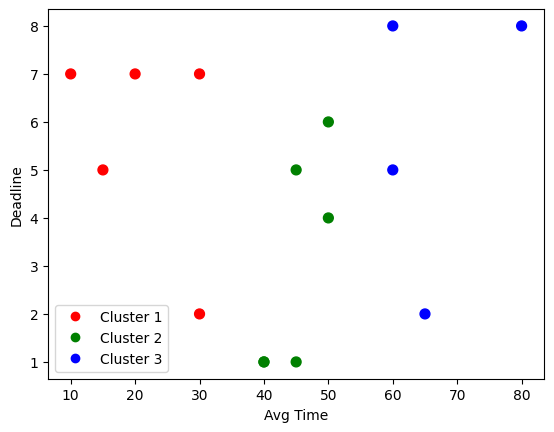

In [118]:
# Crear una lista de diccionarios a partir del diccionario de tareas
task_dicts = [task.__dict__ for task in dictTasks.values()]

# Crear un marco de datos de pandas a partir de la lista de diccionarios
df = pd.DataFrame(task_dicts)

#creo los colores
colors = ['red', 'green', 'blue']

# Seleccionar las columnas que se utilizarán para el clustering
columns = ['avgTime', 'deadline']
X = df[columns].to_numpy()

# Realizar el clustering con KMeans
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)

# Graficamos los resultados
plt.scatter(X[:, 0], X[:, 1], c=[colors[i] for i in labels], s=50, )
plt.xlabel('Avg Time')
plt.ylabel('Deadline')

# Agregar una leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=f'Cluster {i+1}', linestyle='') for i, color in enumerate(colors)]
plt.legend(handles=legend_elements)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


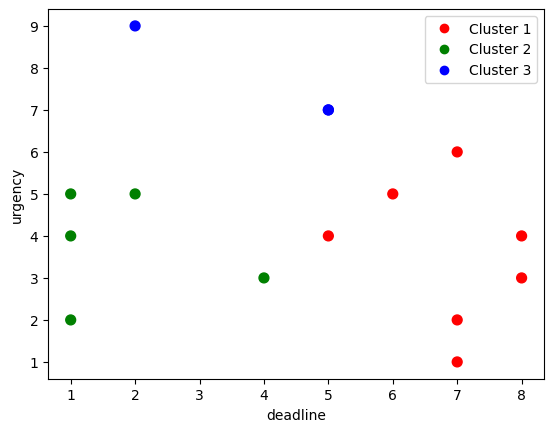

In [119]:
# Crear una lista de diccionarios a partir del diccionario de tareas
task_dicts = [task.__dict__ for task in dictTasks.values()]

# Crear un marco de datos de pandas a partir de la lista de diccionarios
df = pd.DataFrame(task_dicts)

#creo los colores
colors = ['red', 'green', 'blue']

# Seleccionar las columnas que se utilizarán para el clustering
columns = ['deadline', 'urgency']
X = df[columns].to_numpy()

# Realizar el clustering con KMeans
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)

# Graficamos los resultados
plt.scatter(X[:, 0], X[:, 1], c=[colors[i] for i in labels], s=50, )
plt.xlabel('deadline')
plt.ylabel('urgency')

# Agregar una leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=f'Cluster {i+1}', linestyle='') for i, color in enumerate(colors)]
plt.legend(handles=legend_elements)

plt.show()

In [121]:
#Podemos predecir cualquier nueva tarea a que cluster pertenecerán
# task.avgTime, task.timeStart, task.urgency, task.deadline

# Creamos una función para clasificar automáticamente cualquier tarea nueva que se añada a la base de datos

def predict_task_cluster( avgTime, timeStart, urgency, deadline):
    # Crear un array con las características de la nueva tarea
    new_task_features = [ avgTime, timeStart, urgency, deadline]
    
    # Predecir el cluster de la nueva tarea
    predicted_cluster = kmeans.predict([new_task_features])
    
    # Devolver el cluster predicho
    return predicted_cluster[0]


# Prueba de predicción de tiempo real vs tiempo precalculado que toman las tareas

Para crear un modelo de regresión que prediga la duración real de una tarea, primero debemos cargar los datos de entrenamiento y prueba en Python.

In [122]:
# Cargamos los datos de entrenamiento y prueba en dataframes
train_data = pd.read_csv("agentTaskLog.csv")
test_data = pd.read_csv("agentTaskList.csv")


A continuación, debemos limpiar y preprocesar los datos para asegurarnos de que sean adecuados para el modelo. Esto incluye eliminar cualquier dato innecesario o faltante, convertir los datos categóricos en valores numéricos y normalizar los datos para que estén en la misma escala.

In [123]:
# Asegurarse de que las columnas a eliminar estén presentes en ambos conjuntos de datos
cols_to_drop = ["TaskID", "Name", "Parent", "Location", "Involves", "BestOn"]
train_data = train_data.reindex(columns=train_data.columns.tolist() + cols_to_drop)
test_data = test_data.reindex(columns=test_data.columns.tolist() + cols_to_drop)

# Eliminar columnas innecesarias para la predicción
train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)

# Eliminar columnas adicionales en el conjunto de datos de prueba que no están presentes en el conjunto de datos de entrenamiento
cols_to_drop_extra = ["timeEnds", "dayOfWeek"]
train_data = train_data.drop(cols_to_drop_extra, axis=1)

# Convertir las columnas categóricas en valores numéricos usando one-hot encoding
train_data = pd.get_dummies(train_data, columns=[ "IsHobby" ])
test_data = pd.get_dummies(test_data, columns=[ "IsHobby" ])

# Normalizar los datos usando la biblioteca Scikit-learn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [ ]:
train_data

,TaskType,AvgTime,Urgency,TimeStart,Deadline,Recurrency,IsHobby_False,IsHobby_True
0,1,40,5,480,1,7,1,0
1,3,50,6,530,1,7,1,0
2,4,65,9,600,2,2,1,0
3,1,40,4,720,1,7,1,0
4,1,40,5,485,1,7,1,0
5,2,45,2,525,1,6,1,0
6,7,20,1,600,7,2,0,1
7,2,60,4,640,4,3,1,0
8,1,55,3,730,1,7,1,0
9,4,60,8,800,3,4,1,0


In [ ]:
test_data

,TaskType,AvgTime,Urgency,TimeStart,Deadline,Recurrency,IsHobby_False,IsHobby_True
0,1,40,5,480,1,7,1,0
1,2,45,2,525,1,6,1,0
2,3,30,5,530,2,7,1,0
3,4,60,7,590,5,5,1,0
4,4,65,9,600,2,2,1,0
5,5,10,2,540,7,4,1,0
6,6,15,7,605,5,2,1,0
7,1,40,4,720,1,7,1,0
8,5,50,3,630,4,5,1,0
9,7,20,1,660,7,2,0,1


In [124]:
train_data[["AvgTime", "Urgency", "Recurrency", "Deadline"]] = scaler.fit_transform(train_data[["AvgTime", "Urgency", "Recurrency", "Deadline"]])
test_data[["AvgTime", "Urgency", "Recurrency", "Deadline"]] = scaler.transform(test_data[["AvgTime", "Urgency", "Recurrency", "Deadline"]])

Una vez que los datos estén preparados, podemos entrenar el modelo de regresión. Usamos la biblioteca Scikit-learn para crear y ajustar el modelo a los datos de entrenamiento.

In [125]:
# Creamos el modelo de regresión lineal
model = LinearRegression()

# Seleccionamos las columnas de características y la columna objetivo en los datos de entrenamiento
X_train = train_data.drop(["AvgTime"], axis=1)
y_train = train_data["AvgTime"]

# Ajustamos el modelo a los datos de entrenamiento
model.fit(X_train, y_train)


LinearRegression()

Finalmente, podemos utilizar el modelo entrenado para hacer predicciones sobre los datos de prueba. Podemos seleccionar las mismas columnas de características en los datos de prueba y usar el método predict() del modelo para hacer predicciones.

In [126]:
# Seleccionamos las columnas de características en los datos de prueba
X_test = test_data.drop(["AvgTime"], axis=1)

# Hacemos predicciones sobre los datos de prueba
y_pred = model.predict(X_test)


In [127]:
y_pred

array([-0.5733763 , -0.9763492 , -0.69200461, -0.32320986,  1.40902181,
       -1.89137162,  0.26601077, -0.13232488, -0.95853833, -0.58268628,
       -0.65450219, -0.538609  ,  0.22297996, -0.69064389, -0.59758016])

Ahora tendremos un array y_pred con las predicciones para la duración de cada tarea en la base de prueba. Para evaluar la calidad del modelo, podemos comparar las predicciones con los valores reales de duración en la base de prueba.

Una métrica comúnmente usada para evaluar modelos de regresión es el coeficiente de determinación R2. Este coeficiente mide la proporción de la varianza en los datos que es explicada por el modelo. Un valor de R2 cercano a 1 indica que el modelo ajusta bien a los datos, mientras que un valor cercano a 0 indica que el modelo no explica bien la varianza en los datos.

Podemos calcular el valor de R2 para nuestro modelo usando la función r2_score de la biblioteca scikit-learn:

In [128]:
y_true = test_data["AvgTime"]

# comparar los valores reales normalizados con los valores predichos
r2 = r2_score(y_true, y_pred)
print('R2 score:', r2)


R2 score: 0.23049686074912712


El valor del R2 score es un número entre 0 y 1 que indica cuánta varianza en la variable objetivo (en este caso, la columna "AvgTime" en los datos de prueba) se puede explicar por las variables predictoras (las otras columnas en los datos). Cuanto mayor sea el R2 score, mejor será la capacidad del modelo para predecir los valores de la variable objetivo. En este caso, el R2 score obtenido es de 0.23, lo que sugiere que el modelo no explica muy bien la varianza en los datos y tiene un desempeño limitado en la predicción de la variable objetivo.

También podemos visualizar los resultados del modelo usando un gráfico de dispersión. En este gráfico, podemos representar en el eje x los valores reales de duración y en el eje y las predicciones del modelo. Idealmente, los puntos deberían estar alineados con la línea diagonal, lo que indicaría que las predicciones coinciden con los valores reales.

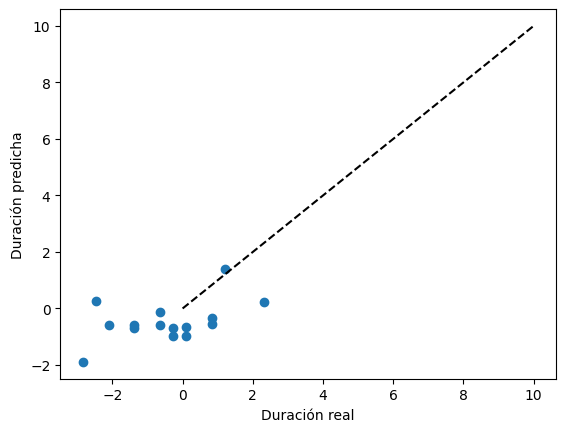

In [129]:
plt.scatter(y_true, y_pred)
plt.plot([0, 10], [0, 10], '--k')
plt.xlabel('Duración real')
plt.ylabel('Duración predicha')
plt.show()

Como se puede ver el ajuste aun no es muy confiable, el agente podria esperar a tener un ajuste de al menos 0.7 antes de usar esta prediccion para asignar valores de tiempo a las tareas.

In [130]:
def r2_confidence(r2_value):
    if r2_value < 0.2:
        print("Los resultados no son muy confiables")
    elif r2_value < 0.4:
        print("Los resultados son moderadamente confiables")
    elif r2_value < 0.6:
        print("Los resultados son bastante confiables")
    elif r2_value < 0.8:
        print("Los resultados son muy confiables")
    else:
        print("Los resultados son extremadamente confiables")

print("Nivel de confianza actual: ")
r2_confidence(r2)

Nivel de confianza actual: 
Los resultados son moderadamente confiables


# Optimizando el cálculo de la urgencia

In [134]:
# Recálculo de la urgencia.

def findUrgencyGroup(agentTaskLog: pd.DataFrame) -> pd.DataFrame:
    """Metodo para hallar tipo de urgencia mediante cluster KMeans"""
    
    def encodeCategorical(agentTaskLog: pd.DataFrame):
        dfEncoded = agentTaskLog.copy()
        #One hot encoding o label encoding a columns str del set de datos
        dfEncoded["EncodedLocation"] = LabelEncoder().fit_transform(dfEncoded["Location"])
        dfEncoded["EncodedIsHobby"] = dfEncoded["IsHobby"].apply(lambda x: 1 if x else 0)
        dfEncoded["EncodedBestOn"] = LabelEncoder().fit_transform(dfEncoded["BestOn"])
        return dfEncoded
    
    
    clustersDf = agentTaskLog.copy() #copio dataframe de entrada para no sobreescribirlo
    clustersDf = encodeCategorical(clustersDf)
    X = clustersDf[["AvgTime","Deadline","EncodedLocation","EncodedIsHobby"]]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    clustersDf["Group"] = kmeans.labels_
    print(f"Silhouette score of KMeans: {silhouette_score(X,kmeans.labels_)}")
    return clustersDf[["AvgTime","Deadline","EncodedLocation","EncodedIsHobby","Urgency","Group"]]


def predictTaskUrgency(clusters_df:pd.DataFrame) -> pd.DataFrame:
    def testSVM(X,Y) -> dict:
        svr = SVR()
        svr.fit(X,Y) #entrenamiento del modelo
        svrPrediction = svr.predict(X)
        r2 = r2_score(Y, svrPrediction) #r2 del modelo
        mseMetric = mse(Y,svrPrediction)
        return {
            "r2":r2,
            "mse":mseMetric,
            "prediction":svrPrediction
        }


    def testLinearRegression(X,Y) -> dict:
        linearRegression = LinearRegression()
        linearRegression.fit(X,Y) #entrenamiento del modelo
        lrPrediction = linearRegression.predict(X)
        r2 = r2_score(Y,lrPrediction)
        mseMetric = mse(Y,lrPrediction)
        return {
            "r2":r2,
            "mse":mseMetric,
            "prediction":lrPrediction
        }
    
    def appendToDataFrameMetrics(urgencyDf:pd.DataFrame, mse:float, r2:float) -> pd.DataFrame:
        metricsDf = urgencyDf.copy()
        metricsDf["r2Metric"] = r2
        metricsDf["mseMetric"] = mse
        return metricsDf    
    
    
    urgencyDf = clusters_df.copy() #copio dataframe de entrada para no sobreescribirlo
    dataScaler = StandardScaler()
    trainData = pd.DataFrame( #normalizar los datos de entrada
        columns=clusters_df.columns,
        data = dataScaler.fit_transform(urgencyDf)
    )
    X = trainData.drop(columns = ["Urgency"])
    Y = trainData["Urgency"]
    lrResults = testLinearRegression(X,Y)
    svmResults = testSVM(X,Y)
    XLr = X
    XLr["Urgency"] = lrResults["prediction"]
    XLr = pd.DataFrame(
        columns= urgencyDf.columns,
        data = dataScaler.inverse_transform(XLr)
        )
    XSvm = X
    XSvm["Urgency"] = svmResults["prediction"]
    XSvm = pd.DataFrame(
        columns= urgencyDf.columns,
        data = dataScaler.inverse_transform(XSvm) 
    )

    #si el r2 de ambos es igual buscar el modelo que menos tenga mse
    if lrResults["r2"] == svmResults["r2"]: 
        if lrResults["mse"] < svmResults["mse"]: #retorno prediccion del SVM
            urgencyDf = appendToDataFrameMetrics(XSvm,
                                                 svmResults["mse"],
                                                 svmResults["r2"])
            return urgencyDf
        #retorno prediccion de la regresion lineal
        urgencyDf = appendToDataFrameMetrics(XLr,
                                            lrResults["mse"],
                                            lrResults["r2"])
        return urgencyDf
    elif lrResults["r2"] < svmResults["r2"]:
        urgencyDf = appendToDataFrameMetrics(XSvm,
                                            svmResults["mse"],
                                            svmResults["r2"])
        return urgencyDf
    urgencyDf = appendToDataFrameMetrics(XLr,
                                        lrResults["mse"],
                                        lrResults["r2"])
    return urgencyDf

df = pd.read_csv("./agentTaskLog.csv")
clustersDf = findUrgencyGroup(df)
urgencyDf = predictTaskUrgency(clustersDf)

urgencyDf   

Silhouette score of KMeans: 0.535974272590046


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,AvgTime,Deadline,EncodedLocation,EncodedIsHobby,Urgency,Group,r2Metric,mseMetric
0,40.0,1.0,1.0,0.0,7.451379,0.445814,0.664179,0.335821
1,50.0,1.0,1.0,0.0,2.589655,0.789028,0.664179,0.335821
2,65.0,2.0,0.0,0.0,2.589655,1.069844,0.664179,0.335821
3,40.0,1.0,4.0,0.0,7.451379,0.240239,0.664179,0.335821
4,40.0,1.0,1.0,0.0,7.451379,0.445814,0.664179,0.335821
5,45.0,1.0,1.0,0.0,7.451379,0.463092,0.664179,0.335821
6,20.0,7.0,1.0,1.0,7.451379,-0.276924,0.664179,0.335821
7,60.0,4.0,1.0,0.0,2.589655,1.077328,0.664179,0.335821
8,55.0,1.0,4.0,0.0,2.589655,0.134126,0.664179,0.335821
9,60.0,3.0,1.0,0.0,2.589655,1.063043,0.664179,0.335821


In [135]:
# Definir variables de entrada y salida
urgencia = ctrl.Antecedent(np.arange(1, 11, 1), 'urgencia')
prioridad = ctrl.Consequent(np.arange(0, 11, 1), 'prioridad')

# Definir los conjuntos difusos y las funciones de pertenencia correspondientes
urgencia['muy_baja'] = fuzz.trimf(urgencia.universe, [1, 1, 3])
urgencia['baja'] = fuzz.trimf(urgencia.universe, [1, 3, 5])
urgencia['media'] = fuzz.trimf(urgencia.universe, [3, 5, 7])
urgencia['alta'] = fuzz.trimf(urgencia.universe, [5, 7, 9])
urgencia['muy_alta'] = fuzz.trimf(urgencia.universe, [7, 10, 10])

prioridad['baja'] = fuzz.trimf(prioridad.universe, [0, 0, 5])
prioridad['media'] = fuzz.trimf(prioridad.universe, [0, 5, 10])
prioridad['alta'] = fuzz.trimf(prioridad.universe, [5, 10, 10])

# Definir las reglas difusas
regla1 = ctrl.Rule(urgencia['muy_baja'], prioridad['baja'])
regla2 = ctrl.Rule(urgencia['baja'], prioridad['baja'])
regla3 = ctrl.Rule(urgencia['media'], prioridad['media'])
regla4 = ctrl.Rule(urgencia['alta'], prioridad['alta'])
regla5 = ctrl.Rule(urgencia['muy_alta'], prioridad['alta'])

# Definir el sistema de control difuso
sistema = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5])
asignar_prioridad = ctrl.ControlSystemSimulation(sistema)

def escribirPrioridad(prioridad):
    # Imprimir la prioridad asignada en forma de cadena de texto
    if prioridad_tarea <= 2.5:
        print("La prioridad de la tarea es baja")
    elif prioridad_tarea <= 7.5:
        print("La prioridad de la tarea es media")
    else:
        print("La prioridad de la tarea es alta")

priorityList = []
for i,urgency in enumerate(urgencyDf["Urgency"]):
    asignar_prioridad.input['urgencia'] = urgency
    asignar_prioridad.compute()
    prioridad_tarea = asignar_prioridad.output['prioridad']
    priorityList.append(prioridad_tarea)
urgencyDf["Priority"] = priorityList



# """
# for clave, valor in dictTasks.items():
#     print("asigno Prioridad para: " +clave +", que tiene urgencia: "+ str(round(valor.urgency,2)))

#     # Asignar un valor de urgencia para la tarea de desayunar
#     asignar_prioridad.input['urgencia'] = valor.urgency

#     # Calcular el resultado del sistema de control difuso
#     asignar_prioridad.compute()

#     # Obtener la salida (prioridad)
#     prioridad_tarea = asignar_prioridad.output['prioridad']
#     print('La prioridad de la tarea es:', round(prioridad_tarea,2))
#     valor.prioridad= prioridad_tarea
#     escribirPrioridad(valor.prioridad)
#     """

In [137]:
df = df[["TaskID", "Name"]].reset_index()
urgencyDf = urgencyDf.reset_index()
tasksDf = urgencyDf.join(df, on=["index"], how="inner", lsuffix="_left", rsuffix="_right")
tasksDf.drop(columns=["level_0", "index_left", "index_right"], inplace = True)
tasksDf.sort_values(by=["Priority"],ascending=False)

,index,AvgTime,Deadline,EncodedLocation,EncodedIsHobby,Urgency,Group,r2Metric,mseMetric,Priority,TaskID,Name
0,0,40.0,1.0,1.0,0.0,7.451379,0.445814,0.664179,0.335821,8.264072,1,desayunar
6,6,20.0,7.0,1.0,1.0,7.451379,-0.276924,0.664179,0.335821,8.264072,4,escuchar musica
18,18,40.0,2.0,1.0,0.0,7.451379,0.470272,0.664179,0.335821,8.264072,5,jugar con mascota
16,16,45.0,1.0,1.0,0.0,7.451379,0.463092,0.664179,0.335821,8.264072,2,desayunar
15,15,30.0,2.0,1.0,0.0,7.451379,0.427899,0.664179,0.335821,8.264072,1,regar las plantas
10,10,30.0,2.0,1.0,0.0,7.451379,0.427899,0.664179,0.335821,8.264072,1,bañarse
5,5,45.0,1.0,1.0,0.0,7.451379,0.463092,0.664179,0.335821,8.264072,2,bañarse
4,4,40.0,1.0,1.0,0.0,7.451379,0.445814,0.664179,0.335821,8.264072,1,desayunar
3,3,40.0,1.0,4.0,0.0,7.451379,0.240239,0.664179,0.335821,8.264072,8,almorzar con amigos
20,20,40.0,7.0,1.0,1.0,7.451379,-0.276924,0.664179,0.335821,8.264072,9,escuchar musica
